77.1730325988 96 0.803885756238
ScatterData_Burgula_B-539.csv probably has Double Trends


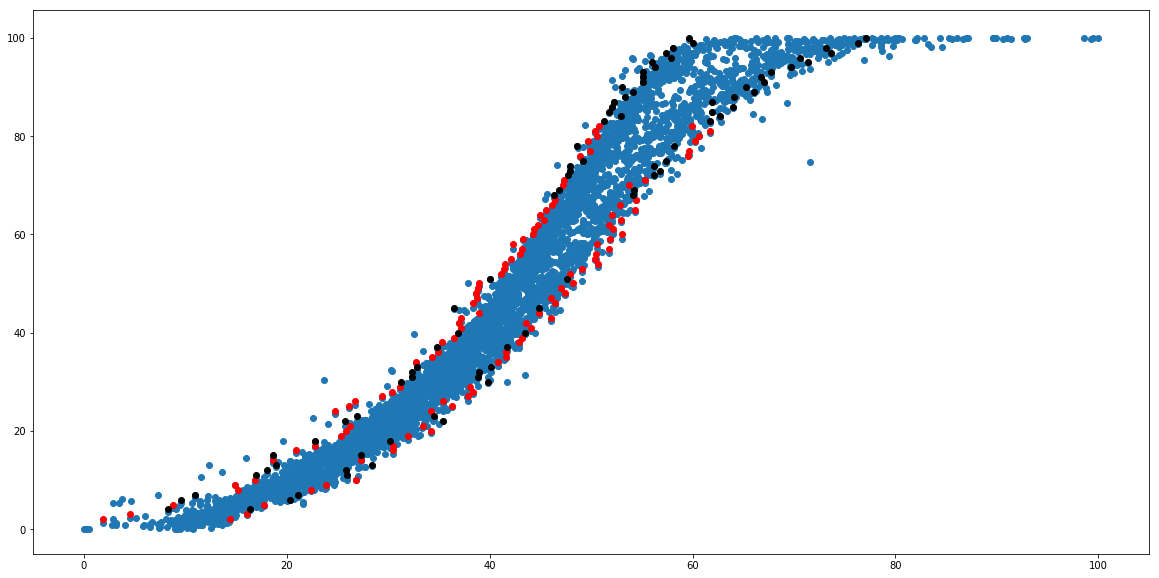

73.2289040861 96 0.76280108423
ScatterData_Burgula_B-531.csv probably has Double Trends


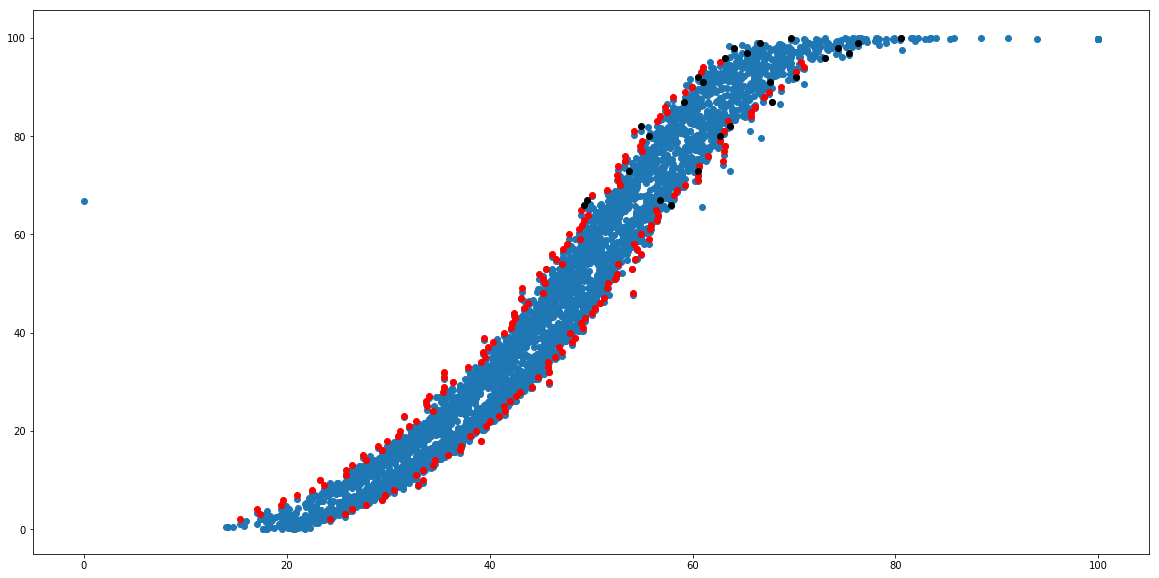

116.286619994 95 1.22406968415
ScatterData_Burgula_B-515.csv probably has Double Trends


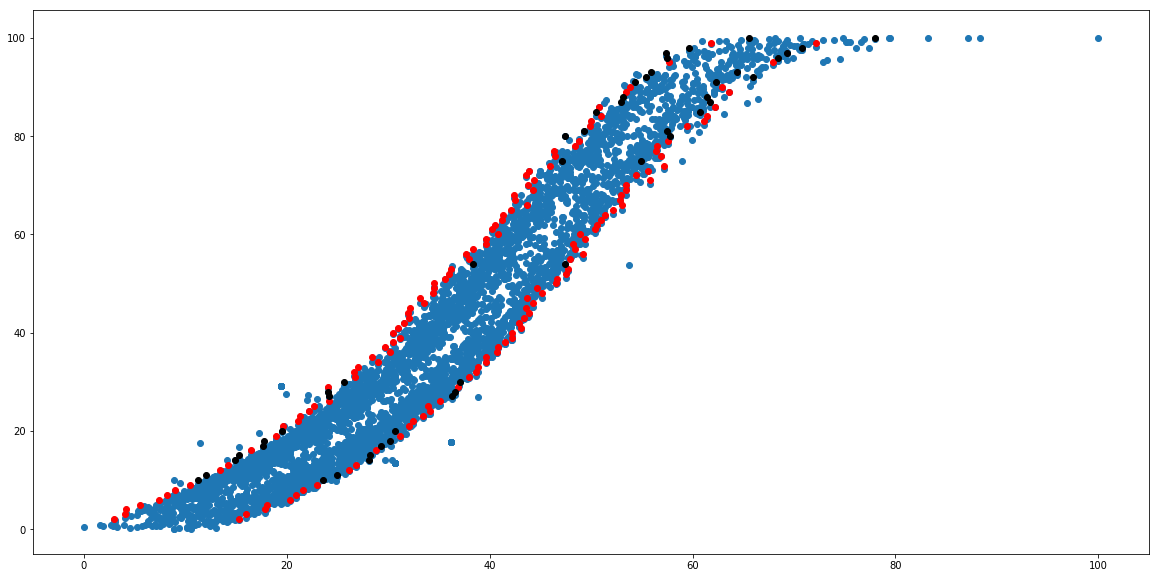

159.024338786 96 1.65650352902
ScatterData_Burgula_B-528.csv probably has Double Trends


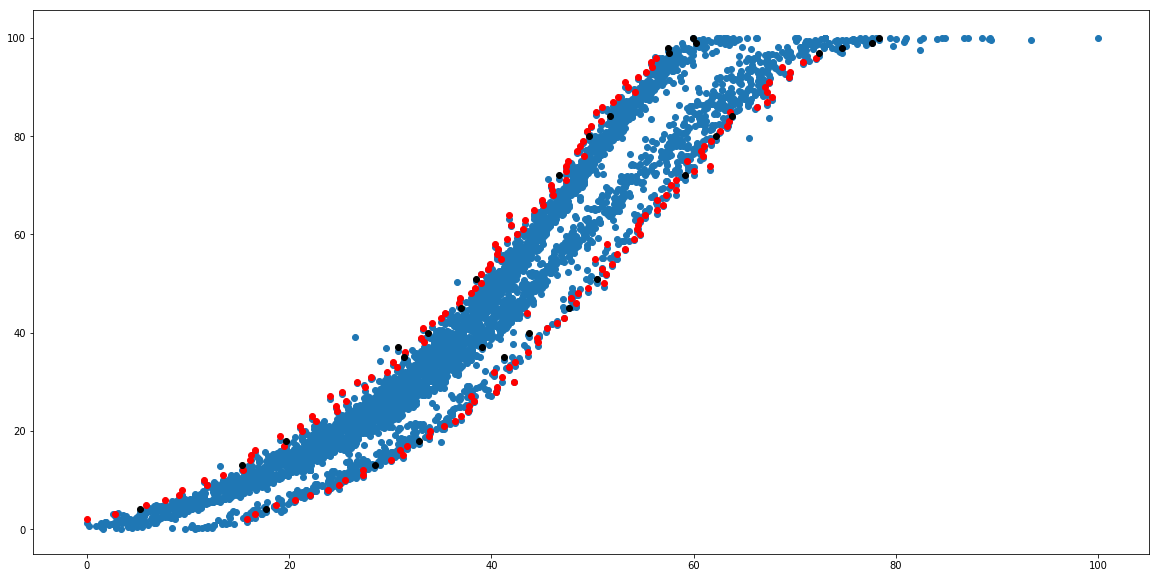

67.7970424156 96 0.706219191829
ScatterData_Burgula_B-525 (1).csv probably has Double Trends


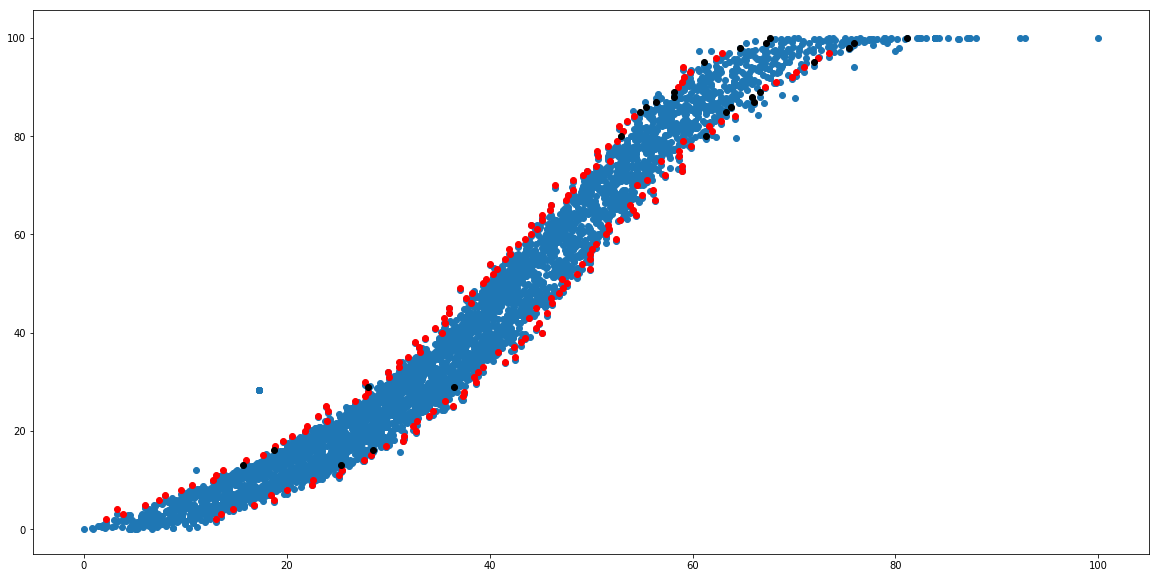

79.1209070102 90 0.879121189002
ScatterData_Burgula_B-525.csv probably has Double Trends


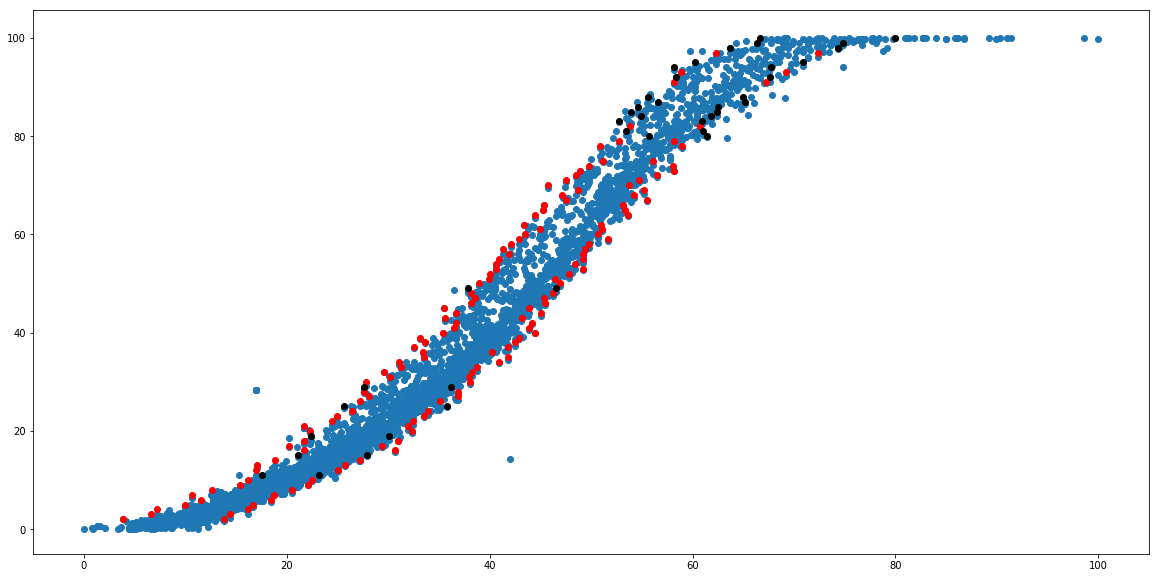

105.709533742 89 1.18774757014
ScatterData_Burgula_B-515 (1).csv probably has Double Trends


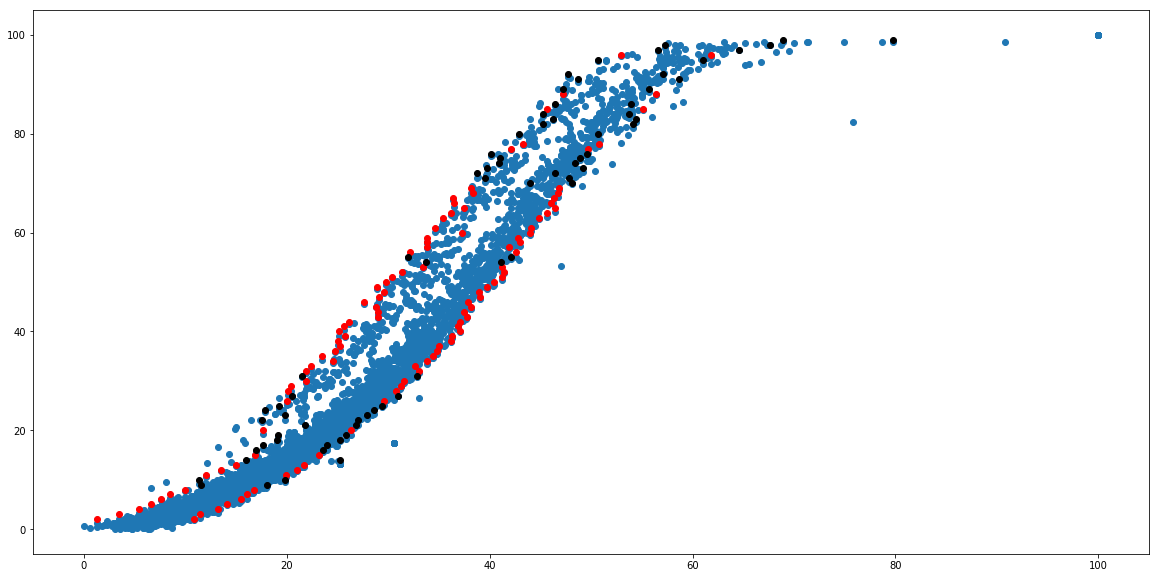

In [1]:
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def max_space_find(work_list, g0, const_density_right=4, const_density_left=4,
                   total_density_multiplier=0.6, limit_max_space=2, reduction_factor=0.3):
    dt_work_list = np.sort(work_list)
    #get spaces
    max_space = 0
    max_space_i = -1
    max_space_i_swp = 0

    for i in range(dt_work_list.shape[0] - 1):
        if max_space < dt_work_list[i + 1] - dt_work_list[i]:
            max_space = dt_work_list[i + 1] - dt_work_list[i]
            max_space_i = i
            max_space_i_swp = dt_work_list[i]
        else:
            continue

    density_left = max_space_i
    density_right = dt_work_list.shape[0] - (max_space_i)

    if max_space > limit_max_space:
        max_space = limit_max_space
    
    
    if ((density_right < np.min([const_density_right, total_density_multiplier * dt_work_list.shape[0]])) or
           (density_left < np.min([const_density_left, total_density_multiplier * dt_work_list.shape[0]]))):
        return {
            'g0': g0,
            'space': max_space * reduction_factor,
            'swp_i': max_space_i_swp
        }
    

    return {
        'g0': g0,
        'space': max_space,
        'swp_i': max_space_i_swp
    }

data_path = '/home/mytrah-pc/Mytrah_Adithya/data_turbine/dt/'
for f in listdir(data_path):
    if f == 'dt':
        continue
    data_set = pd.read_csv(data_path + f)
    if 'TurbineState' not in data_set:
        continue

    data_set = data_set[['Timestamp', 'WindSpeed', 'ActivePower', 'TurbineState']]
    data_set = data_set[data_set['ActivePower'] > 0]
    data_set = data_set[data_set['TurbineState'] == 100]
    min_WindSpeed = data_set['WindSpeed'].min()
    min_ActivePower = data_set['ActivePower'].min()
    normalize_WindSpeed_factor = data_set['WindSpeed'].max() - min_WindSpeed
    normalize_ActivePower_factor = data_set['ActivePower'].max() - min_ActivePower
    data_set['scaled_WindSpeed'] = ((data_set['WindSpeed'] - min_WindSpeed) * 100 / normalize_WindSpeed_factor)
    data_set['scaled_ActivePower'] = ((data_set['ActivePower'] - min_ActivePower) * 100 / normalize_ActivePower_factor)

    def rounding_method(multiply_factor, round_off_by_factor):
        return lambda number: int(number * multiply_factor) + round_off_by_factor - int(number * multiply_factor) % round_off_by_factor

    data_set['discrete_ActivePower'] = data_set['scaled_ActivePower'].apply(rounding_method(1, 1))
    data_set.index = pd.to_datetime(data_set['Timestamp'])
    del data_set['Timestamp']

    if data_set.shape[0] < 10:
        continue
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20, 10))
    plt.scatter(data_set['scaled_WindSpeed'], data_set['scaled_ActivePower'])
#     plt.show()
#     plt.figure(figsize=(20, 10))
#     plt.scatter(data_set['scaled_WindSpeed'], data_set['discrete_ActivePower'])
    from scipy.stats import norm

    from sklearn.cluster import KMeans, DBSCAN
    n_kmeans_clusters = 14
    kmeans_alg_obj = KMeans(n_clusters=n_kmeans_clusters)
    dbscan_alg_obj = DBSCAN(eps=0.7, min_samples=1)
    previous_width = -1
    threshold_width_deviation = 1.8
    allowed_width_deviation = threshold_width_deviation
    epsilon_deviation = 0.33
    change_width_for = {}
    dt_data = []
    weight_min_width = 0.9
    weight_max_width = 0.1
    weight_max_deviation = 0.6
    weight_min_deviation = 0.4
    allowed_group_wind_speed_deviation = 0.13
    min_points_in_group = 4
    limit_elements_in_group_std = 1.6
    limit_next_center_std = 0.5
    right_diff_limit = 5
    right_most_dbkstd_limit = 1.4
    left_most_dbkstd_limit = 1.4

    for group in data_set.groupby('discrete_ActivePower'):

        work_group = group[1].copy()
        work_group['dbscan_label'] = dbscan_alg_obj.fit_predict(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
        work_group = work_group[work_group['dbscan_label'] != -1].copy()
        bool_use_for_dt = 0
        
        if group[0] > 5:
            bool_use_for_dt = 1

        if work_group.shape[0] <= n_kmeans_clusters:
            
            if bool_use_for_dt == 1:
                dt_work_list = np.sort(work_group['scaled_WindSpeed'])
                if np.std([dt_work_list[0], dt_work_list[-1]]) <= np.max([threshold_width_deviation, allowed_width_deviation]):
                    dt_data.append(max_space_find(dt_work_list, group[0]))
        
            continue


        kmeans_alg_obj.fit(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
        work_group['kmeans_label'] = kmeans_alg_obj.labels_
        label_positions = [i[0] for i in sorted(enumerate(kmeans_alg_obj.cluster_centers_[:,0]), key=lambda x:x[1])]
        sorted_values = np.sort(kmeans_alg_obj.cluster_centers_[:,0], axis=0)
        current_width = sorted_values[-1] - sorted_values[0]

#         for grp in work_group.groupby('dbscan_label'):
#             plt.scatter(grp[1]['scaled_WindSpeed'], grp[1]['discrete_ActivePower'])



        if previous_width == -1:
            previous_width = current_width
            continue

        if np.std([previous_width, current_width]) < allowed_width_deviation:
            allowed_width_deviation = weight_min_deviation * np.min([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation]) \
                                    + weight_max_deviation * np.max([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation])
            plt.scatter(work_group['scaled_WindSpeed'].min(), group[0], c='#ff0000')
            plt.scatter(work_group['scaled_WindSpeed'].max(), group[0], c='#ff0000')
            previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])
            
            if bool_use_for_dt == 1:
                dt_work_list = np.sort(work_group['scaled_WindSpeed'])
                dt_data.append(max_space_find(dt_work_list, group[0]))
            
            continue

        m = 0
        n = -1



        while (np.std([previous_width, current_width]) > allowed_width_deviation) and (current_width > previous_width):
            _group_kmeans_filter_m = work_group[work_group['kmeans_label'] == label_positions[m]]

            if ((n < -(n_kmeans_clusters - 2))
                    or (((np.std(_group_kmeans_filter_m['scaled_WindSpeed']) < allowed_group_wind_speed_deviation)
                            or (_group_kmeans_filter_m.shape[0] < min_points_in_group))
                        and np.std([sorted_values[m], sorted_values[m + 1]]) > limit_next_center_std)):
                m = m + 1
                n = -1

            if ((np.std(_group_kmeans_filter_m['scaled_WindSpeed']) > limit_elements_in_group_std) 
                    and (work_group[work_group['kmeans_label'] == label_positions[m]].shape[0] < min_points_in_group)):
                n = m
                break

            if m > (n_kmeans_clusters - 2):
                m = 0
                n = -1
                break

            n = n - 1
            current_width = sorted_values[n] - sorted_values[m]


        change_width_for[group[0]] = {}

        _max_dbscan_label = work_group.loc[work_group[work_group['kmeans_label'] == label_positions[n]]['scaled_WindSpeed'].idxmax()]['dbscan_label']
        _min_dbscan_label = work_group.loc[work_group[work_group['kmeans_label'] == label_positions[m]]['scaled_WindSpeed'].idxmin()]['dbscan_label']

        right_most_opt_dbscan = work_group[work_group['dbscan_label'] == _max_dbscan_label]['scaled_WindSpeed'].max()
        right_most_opt_kmeans = work_group[work_group['kmeans_label'] == label_positions[n]]['scaled_WindSpeed'].max()

        left_most_opt_dbscan = work_group[work_group['dbscan_label'] == _min_dbscan_label]['scaled_WindSpeed'].min()
        left_most_opt_kmeans = work_group[work_group['kmeans_label'] == label_positions[m]]['scaled_WindSpeed'].min()

        if np.std([right_most_opt_dbscan, right_most_opt_kmeans]) < right_most_dbkstd_limit:
            right_most = right_most_opt_dbscan
        else:
            right_most = right_most_opt_kmeans

        if np.std([left_most_opt_dbscan, left_most_opt_kmeans]) < left_most_dbkstd_limit:
            left_most = left_most_opt_dbscan
        else:
            left_most = left_most_opt_kmeans

        current_width = right_most - left_most

        change_width_for[group[0]]['l'] = left_most
        change_width_for[group[0]]['r'] = right_most
        previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])

        m = 0
        n = -1

        if bool_use_for_dt == 1:
            dt_work_list = work_group[(work_group['scaled_WindSpeed'] >= left_most) \
                                      & (work_group['scaled_WindSpeed'] <= right_most)]['scaled_WindSpeed']

            dt_data.append(max_space_find(dt_work_list, group[0]))
            
    t = 0
    n = 0
    for x in dt_data:
        if x['g0'] != -1:
            t = t + x['space']
            n = n + 1

    for x in change_width_for.keys():
        plt.scatter(change_width_for[x]['l'], x, c='#000000')
        plt.scatter(change_width_for[x]['r'], x, c='#000000')
    
    print t, n, t / n
    if (t >= 63) or ((t / n) >= 0.93):
        print f + ' probably has Double Trends'
    else:
        print f + ' probably does not have Double Trends'

    plt.show()